#### Analysis of gene degree on Baron Human

- Analyze the Baron Human WCSN to obtain the gene degree matrix for different cell types across folds, and identify the top 100 genes with the highest degree for each cell type in each fold.
- For each cell type, obtain the union of the top 100 genes with the highest degree across different folds.

In [ ]:
# Baron_Human degree matrix: Generate the gene degree matrix for each cell type and fold based on WCSN.
! python get_degree_matrix.py -expr ../../dataset/pre_data/scRNAseq_datasets/Baron_Human.npz \
    -ca 0.01 -hvgs 2000 

In [ ]:
import pandas as pd
import numpy as np

# Load the seq_dict file containing label information
seq_dict = np.load('../../dataset/pre_data/scRNAseq_datasets/Baron_Human/seq_dict.npz', allow_pickle=True) 
label = seq_dict['label']

# Load the degree matrix file
matrix_dict = np.load('../../dataset/5fold_data/Baron_Human/degree_matrix_Baron_Human_a0.01_hvgs2000.npz', allow_pickle=True)

# Print the keys in the loaded matrix_dict
print("Keys in loaded matrix_dict:", matrix_dict.files)

# Load str_labels (cell type labels)
str_labels = matrix_dict['str_labels']
print("cell-type: ", str_labels)

# Ensure str_labels has the correct length
print("Length of str_labels:", len(str_labels))

# Iterate over each cell type to access its degree matrix
for k in range(len(str_labels)):
    # Use the string form of k to access the degree matrix for each cell type
    degree_matrix_key = f'{k}'  # Using string format for key
    degree_matrix_dict = matrix_dict[degree_matrix_key].item()   # Unpack to a dictionary
    print(degree_matrix_dict.keys())

    # Create a DataFrame to store the top 100 indices (based on mean degree) for each fold
    fold_top_indices_df = pd.DataFrame()

    # Iterate through each fold (1 to 5)
    for i in range(5):
        fold = i + 1
        cur_fold_degree_matrix = degree_matrix_dict[f'CV_{fold}']
        
        # Compute the mean degree for each row (gene) in the degree matrix
        mean_degree = np.mean(cur_fold_degree_matrix, axis=1)

        # Sort and get the indices of the top 100 maximum values
        top_100_indices = np.argsort(mean_degree)[-100:][::-1]  # Sort, select top 100, and reverse order

        # Add the top 100 indices for the current fold to the DataFrame
        fold_top_indices_df[f'Fold_{fold}'] = top_100_indices

    # Save the top 100 indices for each fold as a .tsv file, with the filename based on the cell type
    cell_type_name = str_labels[k]
    tsv_filename = f'data/Baron_Human/Gene_degree/{cell_type_name}_top100_indices.tsv'
    fold_top_indices_df.to_csv(tsv_filename, sep='\t', index=False)

    # Print confirmation message for the saved file
    print(f"Saved top 100 indices for cell type '{cell_type_name}' to {tsv_filename}")


In [ ]:
import pandas as pd
import os

def read_and_union_tsv(cell_type):
    """
    Read the TSV file for the specified cell type and return the union of top 100 genes across all folds.
    
    Parameters:
    cell_type (str): The name of the cell type
    
    Returns:
    list: A list containing the union of top 100 genes across all folds
    """
    file_path = f'data/Baron_Human/Gene_degree/{cell_type}_top100_indices.tsv'
    
    try:
        # Read the TSV file
        data = pd.read_csv(file_path, sep='\t')
        # Get the union of all columns' unique values
        # Use set.union to combine the unique values from all columns
        union_set = set()
        for col in data.columns:
            union_set.update(data[col].dropna().astype(int))
        
        return list(union_set)
    except FileNotFoundError:
        print(f"Warning: File not found for cell type {cell_type}")
        return []
    except Exception as e:
        print(f"Error processing {cell_type}: {str(e)}")
        return []

def process_cell_types(str_labels):
    """
    Process all cell types in the order provided by str_labels.
    
    Parameters:
    str_labels (list): A list of all cell type names
    
    Returns:
    pd.DataFrame: A DataFrame containing the union of top 100 genes for each cell type
    """
    
    # Create a dictionary to store results
    result_dict = {}
    
    # Process each cell type in the provided order
    for cell_type in str_labels:
        union_genes = read_and_union_tsv(cell_type)
        result_dict[cell_type] = pd.Series(union_genes, dtype='Int64')
        print(f"{cell_type}: {len(union_genes)} genes")
    
    # Convert the result dictionary into a DataFrame
    result_df = pd.DataFrame(result_dict)
    
    return result_df

# Main execution flow

# Load the seq_dict file containing the cell type labels
seq_dict = np.load('../../dataset/5fold_data/Baron_Human/seq_dict.npz', allow_pickle=True) 
# label = seq_dict['label']  # label is not needed in this script
str_labels = seq_dict['str_labels']

# Process all cell types to get the union of top 100 genes
result_df = process_cell_types(str_labels)

# Save the result as a TSV file
output_path = 'data/Baron_Human/Gene_degree/Baron_Human_merged_top100_genes.tsv'
result_df.to_csv(output_path, sep='\t', index=False)
print(f"\nResults saved to: {output_path}")


In [8]:
seq_dict = np.load('../../dataset/5fold_data//Baron_Human/seq_dict.npz', allow_pickle=True) 
genes = seq_dict['gene_symbol']

all_filtered_genes_file = '../../dataset/5fold_data/Baron_Human/Baron_Human_filtered_hvgs2000.npy'

# 得到每一折的基因数量：
# genes_num_all = get_gene_num(all_filtered_genes_file)
all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

filtered_genes = genes[filtered_genes_index]

print(filtered_genes)
print(filtered_genes.shape)
df = pd.DataFrame(filtered_genes, columns=['gene_symbol'])
df.to_csv('data/Baron_Human/Baron_Human_gene_symbol_hvgs2000.tsv',  sep='\t', index=False, header=True)
# print(f"Successfully saved {len(genes)} genes to {output_path}")

(2000,)
['A2M' 'A4GALT' 'AACSP1' ... 'TIMM8A' 'TIMMDC1' 'TJP2']
(2000,)


#### Analysis of edge weight on Baron Human

- Analyze the Baron Human WCSN to identify the top 100 edges with the highest weight for each cell type in each fold.
- For each cell type, obtain the union of the top 100 edges with the highest weight across different folds.

In [ ]:
import numpy as np
import os
import torch
from scipy import sparse
import heapq
from collections import defaultdict

def find_top_edges(matrices, top_k=100):
    """
    Find the top edges with the highest average weight across multiple sparse matrices.
    
    Parameters:
    matrices: List[scipy.sparse.csr_matrix] - List of sparse matrices
    top_k: int - The number of top edges to return
    
    Returns:
    List[tuple] - A list of (node1, node2, avg_weight) tuples sorted by average weight in descending order
    """
    total_matrices = len(matrices)  # Total number of matrices
    edge_weights = defaultdict(float)
    
    # Iterate over all matrices
    for matrix in matrices:
        # Get coordinates and values of non-zero elements
        rows, cols = matrix.nonzero()
        values = matrix.data
        
        # Iterate over each non-zero element
        for i in range(len(rows)):
            # Convert numpy integers to Python integers
            node1 = int(min(rows[i], cols[i]))
            node2 = int(max(rows[i], cols[i]))
            if node1 != node2:  # Ignore self-loops
                # Convert numpy floats to Python floats
                edge_weights[(node1, node2)] += float(values[i])

    # Compute average weight for each edge
    edge_avg_weights = []
    for (node1, node2), weight_sum in edge_weights.items():
        # Ensure all values are Python native types
        avg_weight = float(weight_sum) / float(total_matrices)
        edge_avg_weights.append((int(node1), int(node2), float(avg_weight)))
    
    # Return the top k edges by average weight
    return heapq.nlargest(top_k, edge_avg_weights, key=lambda x: x[2])


def load_and_process_matrices(cell_test_folder, cur_label_idxs):
    """
    Load sparse matrix data for the specified cells.
    
    Parameters:
    file_paths: List[str] - List of sparse matrix file paths
    
    Returns:
    List[scipy.sparse.csr_matrix] - List of sparse matrices
    """
    matrices = []

    for idx in cur_label_idxs:
        data = torch.load(os.path.join(cell_test_folder, f'cell_{idx}.pt'))
        # Get the current edge index and edge weight
        edge_index = data.edge_index
        edge_weight = data.edge_weight
        
        # Get the number of nodes
        num_nodes = data.x.shape[0]  # Extract node count from feature matrix

        # Convert edge_index and edge_weight to numpy arrays
        edges = edge_index.cpu().numpy()
        weights = edge_weight.cpu().numpy()

        # Create sparse matrix from edge_index and edge_weight
        sparse_mat = sparse.csr_matrix(
            (weights, (edges[0], edges[1])),
            shape=(num_nodes, num_nodes)
        )           
        
        matrices.append(sparse_mat)     
    
    return matrices


def save_cell_type_edges(cell_type, fold_edges, save_folder, base_filename):
    """
    Save the top edges for each cell type across different folds.
    
    Parameters:
    cell_type: str - The name of the cell type
    fold_edges: dict - Dictionary containing the top edges for each fold
    save_folder: str - Folder path where the results will be saved
    base_filename: str - Base filename for naming the saved files
    """
    # Create save directory if it doesn't exist
    save_dir = os.path.join(save_folder, f"{base_filename}_top_edges")
    os.makedirs(save_dir, exist_ok=True)
    
    # Build the file path for saving
    filename = os.path.join(save_dir, f"{cell_type}_top_edges.npz")
    
    # Prepare dictionary for saving data
    save_dict = {
        'cell_type': cell_type,
        'base_filename': base_filename
    }
    
    # Add top edges for each fold to the dictionary
    for fold_idx, edges in fold_edges.items():
        # Convert edges to numpy array and ensure proper data types
        edges_array = np.array(edges, dtype=[
            ('node1', 'int32'), 
            ('node2', 'int32'), 
            ('weight', 'float32')
        ])
        save_dict[f'fold_{fold_idx}_edges'] = edges_array        
    
    # Save the data as a .npz file
    np.savez(filename, **save_dict)


In [ ]:
seq_dict = np.load('../../dataset/5fold_data//Baron_Human/seq_dict.npz', allow_pickle=True) 
label = seq_dict['label'] 
str_labels = seq_dict['str_labels']
save_folder = 'data/Baron_Human/'

# Create a dictionary to store the top edges for all folds for each cell type
cell_type_edges = {}

# Iterate through each cell type
for cur_label, cell_type in enumerate(str_labels):
    print("cur_label: ", cur_label)
    print("cell_type: ", cell_type)

    # Dictionary to store top edges for each fold of the current cell type
    fold_edges = {}
    
    # Iterate through each fold (1 to 5)
    for k in range(5):
        k_fold = k + 1
        test_index = seq_dict[f'test_index_{k_fold}']
        label_test = label[test_index]
        cur_label_idxs = np.where(label_test == cur_label)[0].tolist()

        # Define the folder containing the processed data for the current fold
        cell_test_folder = os.path.join(
            "../../dataset/5fold_data/Baron_Human/wcsn_a0.01_hvgs2000", 
            f"test_f{k_fold}", 
            'processed'
        )
        
        # Load the matrices for the current fold and find the top edges
        cur_mat = load_and_process_matrices(cell_test_folder, cur_label_idxs)
        cur_top_edges = find_top_edges(cur_mat)
        
        # Store the top edges for the current fold
        fold_edges[k_fold] = cur_top_edges
    
    # Save the top edges for all folds for the current cell type
    save_cell_type_edges(cell_type, fold_edges, save_folder,  base_filename="Baron_Human")


In [11]:
import numpy as np
import pandas as pd
import os
import glob

def create_edge_strings(edges):
    """Convert edge pairs to string format."""
    return [f"{int(edge[0])}-{int(edge[1])}" for edge in edges]

def process_npz_file(file_path):
    """Process a single npz file and save results."""
    # Extract cell type name from file path
    cell_type = os.path.basename(file_path).replace('_top_edges.npz', '')
    
    # Create output directory
    output_dir = os.path.join(os.path.dirname(file_path), f'{cell_type}_top_edges')
    os.makedirs(output_dir, exist_ok=True)
    
    # Load and process data
    try:
        data = np.load(file_path, allow_pickle=True)
        
        # Process each fold
        for i in range(1, 6):  # 5-fold
            fold_key = f'fold_{i}_edges'
            if fold_key in data:
                edges = data[fold_key]
                edge_strings = create_edge_strings(edges)
                
                # Save to CSV
                output_file = os.path.join(output_dir, f'fold_{i}_edges.csv')
                pd.DataFrame({'edges': edge_strings}).to_csv(output_file, index=False)
                
        print(f"Successfully processed {cell_type}")
        
    except Exception as e:
        print(f"Error processing {cell_type}: {str(e)}")

def process_all_cell_types(base_dir):
    """Process all npz files in the directory."""
    # Find all npz files in the directory
    npz_files = glob.glob(os.path.join(base_dir, '*_top_edges.npz'))
    
    if not npz_files:
        print(f"No npz files found in {base_dir}")
        return
    
    print(f"Found {len(npz_files)} files to process")
    
    # Process each file
    for file_path in npz_files:
        process_npz_file(file_path)
    
    print("Processing complete!")

# # Main execution
# if __name__ == "__main__":
base_dir = 'data/Baron_Human/Baron_Human_top_edges'
process_all_cell_types(base_dir)

Found 13 files to process
Successfully processed acinar
Successfully processed activated_stellate
Successfully processed alpha
Successfully processed beta
Successfully processed delta
Successfully processed ductal
Successfully processed endothelial
Successfully processed epsilon
Successfully processed gamma
Successfully processed macrophage
Successfully processed mast
Successfully processed quiescent_stellate
Successfully processed schwann
Processing complete!


In [ ]:
import numpy as np
import pandas as pd
import os

def get_union_edges(npz_file):
   """Get the union of top edges across all 5 folds for a specific cell type."""
   # Load the npz file
   data = np.load(npz_file, allow_pickle=True)
   
   # Set to store all edges
   all_edges = set()
   
   # Iterate through the 5 folds
   for i in range(1, 6):
       fold_key = f'fold_{i}_edges'
       if fold_key in data:
           edges = data[fold_key]
           # Convert each edge to string format and add to the set
           edge_strings = [f"{int(edge[0])}-{int(edge[1])}" for edge in edges]
           all_edges.update(edge_strings)
   print(list(all_edges))
   return sorted(list(all_edges))  # Return the sorted list of edges


# Load the seq_dict file containing the labels for cell types
seq_dict = np.load('../../dataset/5fold_data/Baron_Human/seq_dict.npz', allow_pickle=True) 
str_labels = seq_dict['str_labels']

cell_types = str_labels.tolist()  # Actual cell type names
print("cell types: ", cell_types)

# Dictionary to store union of edges for each cell type
edges_dict = {}

# Iterate through each cell type and process their corresponding npz files
for cell_type in cell_types:
   npz_file = f'data/Baron_Human/Baron_Human_top_edges/{cell_type}_top_edges.npz'  # Path to npz file
   if os.path.exists(npz_file):
        edges_dict[cell_type] = get_union_edges(npz_file)

# Find the maximum length among all edge lists
max_length = max(len(edges) for edges in edges_dict.values())

# Pad the shorter lists with empty values to match the maximum length
for cell_type in edges_dict:
   if len(edges_dict[cell_type]) < max_length:
       edges_dict[cell_type].extend([''] * (max_length - len(edges_dict[cell_type])))

# Create a DataFrame from the edges dictionary
df = pd.DataFrame(edges_dict)
print(df.columns)

# Save the DataFrame to a TSV file
save_path = 'data/Baron_Human/Baron_Human_top_edges/union_edges.tsv'
df.to_csv(save_path, sep='\t', index=False)

print(f"Save completed: {save_path}")

# Print some basic statistics
print("\nNumber of edges for each cell type:")

for cell_type in cell_types:
   # Count the number of non-empty values
   edge_count = len([x for x in edges_dict[cell_type] if x != ''])
   print(f"{cell_type}: {edge_count} edges")


#### Figure 7A-H, Baron_Human: T-SNE (gene)  

- Analyze the hub genes specific to each cell type, and visualize the results using t-SNE for the third fold cells. Check the degree of the genes corresponding to these cells and examine the distribution of the degree of these genes across different cell types.

In [ ]:
import numpy as np
import os
import torch
import os
pathjoin = os.path.join

# Load the seq_dict file containing label and str_labels
seq_dict = np.load('../../dataset/5fold_data/Baron_Human/seq_dict.npz', allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']

cur_label = 0
matrix_dict = {}
matrix_dict['str_labels'] = str_labels

# Dictionary to store degree matrices for each fold
degree_matrices_for_folds = {}  # Stores the degree matrices for each fold    

# Iterate through each fold (1 to 5)
for k in range(5):
    k_fold = k + 1
    test_index = seq_dict[f'test_index_{k_fold}']
    label_test = label[test_index]

    # Define the folder where processed cell data is stored for the current fold
    cell_test_folder = f'../../dataset/5fold_data/Baron_Human/wcsn_a0.01_hvgs2000/test_f{k_fold}/processed'
    
    degree_matrix = []
    print(test_index.shape)
    # Iterate over the indices in the current test set
    for idx in range(len(test_index)):
        data = torch.load(os.path.join(cell_test_folder, f'cell_{idx}.pt'))
        
        # Get the edge indices and edge weights
        edge_index = data.edge_index
        edge_weight = data.edge_weight
        
        # Generate symmetric edge indices
        row, col = edge_index
        symmetric_edge_index = torch.cat([edge_index, torch.stack([col, row])], dim=1)
        
        # Calculate the degree (gene degree) for each node
        degrees = torch.bincount(symmetric_edge_index[0])
        
        # If the number of nodes is less than the maximum number of genes (2000), pad with zeros
        if degrees.size(0) < 2000:
            degrees = torch.cat([degrees, torch.zeros(2000 - degrees.size(0))])
        
        # Add the degree vector to the degree matrix
        degree_matrix.append(degrees.numpy())

    # Transpose the degree matrix and store it in the dictionary
    degree_matrix = np.array(degree_matrix).T
    print(degree_matrix.shape)
    degree_matrices_for_folds[f'CV_{k_fold}'] = degree_matrix  # Store the degree matrix for each fold

# Save the degree matrices to a file
degree_file = pathjoin('../../dataset/5fold_data/Baron_Human', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')

# Check the structure of the degree_matrices_for_folds dictionary
print(f"Matrix dict structure before saving: {type(degree_matrices_for_folds)}")
for key in degree_matrices_for_folds:
    print(f"Key: {key}, Type: {type(degree_matrices_for_folds[key])}")
    if isinstance(degree_matrices_for_folds[key], dict):  # Ensure it is a dictionary
        for inner_key in degree_matrices_for_folds[key]:
            print(f"  Inner Key: {inner_key}, Type: {type(degree_matrices_for_folds[key][inner_key])}")

# Save the degree matrices dictionary as a .npz file
np.savez(degree_file, **degree_matrices_for_folds)


In [28]:
degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])

(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]


In [16]:
seq_dict = np.load('../../dataset/5fold_data/Baron_Human/seq_dict.npz', allow_pickle=True) 
genes = seq_dict['gene_symbol']

all_filtered_genes_file = '../../dataset/5fold_data//Baron_Human/Baron_Human_filtered_hvgs2000.npy'

all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

gene_hvgs = genes[filtered_genes_index]

print(gene_hvgs)


(2000,)
['A2M' 'A4GALT' 'AACSP1' ... 'TIMM8A' 'TIMMDC1' 'TJP2']


In [ ]:
import pandas as pd

# File containing the union of top 100 genes for different cell types
Baron_Human_union_top_100_genes_file = 'Tables/Baron_Human/Gene_degree/Baron_Human_merged_top100_genes.tsv'
Baron_Human_union_genes = pd.read_csv(Baron_Human_union_top_100_genes_file, sep='\t', dtype=str, header=0)
print(Baron_Human_union_genes.iloc[:5, :5])
columns = Baron_Human_union_genes.columns.tolist()

sets = {}
# Create a set for each cell type's top 100 genes
for col in columns:
    sets[col] = set(Baron_Human_union_genes[col].dropna().values)

# Calculate unique genes for each cell type
unique_genes = {}
for col in columns:
    print("Current cell type: ", col)
    # Calculate genes that only appear in the current cell type's set
    unique = sets[col] - set.union(*[sets[c] for c in columns if c != col])
    unique_genes[col] = unique
    print(f"\nNumber of unique genes only in {col}: {len(unique)}")
    if len(unique) > 0:
        print("List of unique genes:")
        print(unique)


- t-sne

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

# Load seq_dict file containing cell data
seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
# genes_id = seq_dict['gene_id']  # gene_id not used in this script
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']

genes = seq_dict['gene_symbol']

# Load filtered genes list (highly variable genes)
all_filtered_genes_file = '../../dataset/5fold_data//Baron_Human/Baron_Human_filtered_hvgs2000.npy'
all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

# Retrieve the gene symbols for the highly variable genes (HVGs)
gene_hvgs = genes[filtered_genes_index]
print(gene_hvgs)

# Define the path for prediction embeddings
pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_prediction.h5'

# Load embedding data from the prediction file
cell_embedding = pd.read_hdf(pred_path, key='embedding')

# Optionally load additional data such as cell types and predicted probabilities
cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])  # Display the first 5 cell types

# Loop through fold indices (for this example, fold 3)
lst = [2]  # Using fold 3 as the example
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]

    print("Embedding shape:", cur_cell_emb.shape)  # Expected shape should be (n_cells, 64)
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))


    perp = 30  
    ee = 12     
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,       
                n_iter=1000,           
                learning_rate='auto')

    # Perform t-SNE transformation on the cell embeddings
    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    # Plotting the t-SNE results
    plt.figure(figsize=(8, 5))
    # Get unique labels for the cell types in the test set
    unique_labels = np.unique(cell_type['true_cell_type'].loc[barcodes_test])

    # Create color palette for different cell types
    colors = sns.color_palette('husl', n_colors=len(unique_labels))
    color_dict = dict(zip(unique_labels, colors))

    # Plot scatter plot for each unique cell type
    for label in unique_labels:
        mask = cell_type['true_cell_type'].loc[barcodes_test] == label
        plt.scatter(embeddings_2d[mask, 0], 
                    embeddings_2d[mask, 1],
                    c=[color_dict[label]],  # Color each cell type differently
                    label=str_labels[label],  # Use str_labels for label names
                    alpha=0.6,
                    s=20)

    # Add a legend to the plot
    plt.legend(bbox_to_anchor=(1.01, 1),
               loc='upper left',
               borderaxespad=0,
               fontsize=12)

    # Set plot title and axis labels
    plt.title(f'Baron Human/True_label', fontsize=14)    
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    # Adjust layout to avoid clipping of labels
    plt.tight_layout()

    # Save the plot as both SVG and PNG files
    plt.savefig(f'../../result/Figures/Figure_7A.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7A.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    # Display the plot
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Set font to Times New Roman for consistent plotting style
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

# Load the seq_dict file containing metadata for the cells
seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
# genes_id = seq_dict['gene_id']  # genes_id is not used in this script
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']

genes = seq_dict['gene_symbol']

# Load filtered highly variable genes (HVGs) information
all_filtered_genes_file = '../../dataset/5fold_data//Baron_Human/Baron_Human_filtered_hvgs2000.npy'

# Get the indices of the filtered HVGs
all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

# Extract gene symbols for the filtered highly variable genes (HVGs)
gene_hvgs = genes[filtered_genes_index]

print(gene_hvgs)

# Define the path for prediction data
pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_prediction.h5'
# Read the embedding data from the prediction file
cell_embedding = pd.read_hdf(pred_path, key='embedding')

# Optionally, read additional data such as cell types and predicted probabilities
cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])  # Display the first 5 rows of cell type information

# Iterate through fold indices (example: fold 3)
lst = [2]  # Using fold 3 as the example
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]

    print("Embedding shape:", cur_cell_emb.shape)  # Expected shape should be (n_cells, 64)
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30  
    ee = 12     
    tsne = TSNE(n_components=2,     
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,      
                n_iter=1000,          
                learning_rate='auto')

    # Perform t-SNE transformation on the cell embeddings
    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(8, 5))
    unique_labels = np.unique(cell_type['true_cell_type'].loc[barcodes_test])

    colors = sns.color_palette('husl', n_colors=len(unique_labels))
    color_dict = dict(zip(unique_labels, colors))

    for label in unique_labels:
        mask = cell_type['pred_cell_type'].loc[barcodes_test] == label
        plt.scatter(embeddings_2d[mask, 0], 
                    embeddings_2d[mask, 1],
                    c=[color_dict[label]],  # Color each cell type differently
                    label=str_labels[label],  # Use str_labels for label names
                    alpha=0.6,
                    s=20)
        
    plt.title(f'Baron Human/Pred_label', fontsize=16)
    plt.legend(bbox_to_anchor=(1.01, 1),
               loc='upper left',
               borderaxespad=0,
               fontsize=12)

    plt.xlabel('t-SNE 1', fontsize=14, fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14, fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7B.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7B.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    plt.show()


(2000,)
['A2M' 'A4GALT' 'AACSP1' ... 'TIMM8A' 'TIMMDC1' 'TJP2']
(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
CCDC157
Embedding shape: (1712, 64)
Number of unique labels: 13


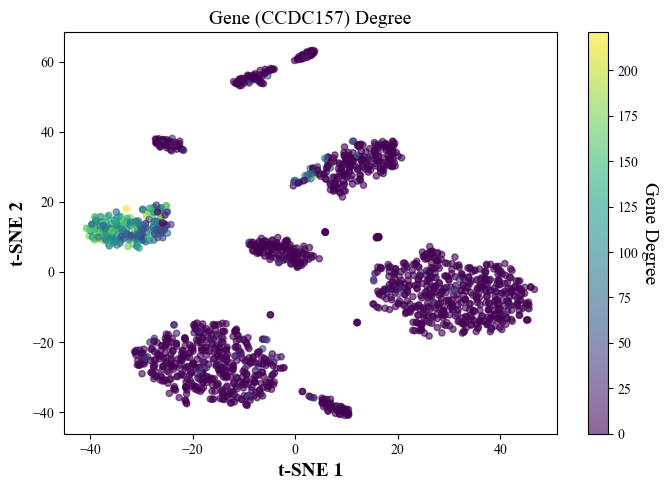

In [34]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os

pathjoin = os.path.join

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']
genes = seq_dict['gene_symbol']

all_filtered_genes_file = '../../dataset/5fold_data/Baron_Human/Baron_Human_filtered_hvgs2000.npy'

all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

gene_hvgs = genes[filtered_genes_index]

print(gene_hvgs)


pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])


degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])


lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]

    print(gene_hvgs[344])
    target_gene_degree = degree_f3[344]
    gene_degrees = target_gene_degree

    print("Embedding shape:", cur_cell_emb.shape)  
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,       
                learning_rate='auto')


    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=gene_degrees,  
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)

    cbar = plt.colorbar(scatter)

    cbar.set_label('Gene Degree', rotation=270, labelpad=15,
                   fontsize=14)

    plt.title(f'Gene (CCDC157) Degree', fontsize=14)
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7E.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7E.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')


    plt.show()

(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
KEL
Embedding shape: (1712, 64)
Number of unique labels: 13


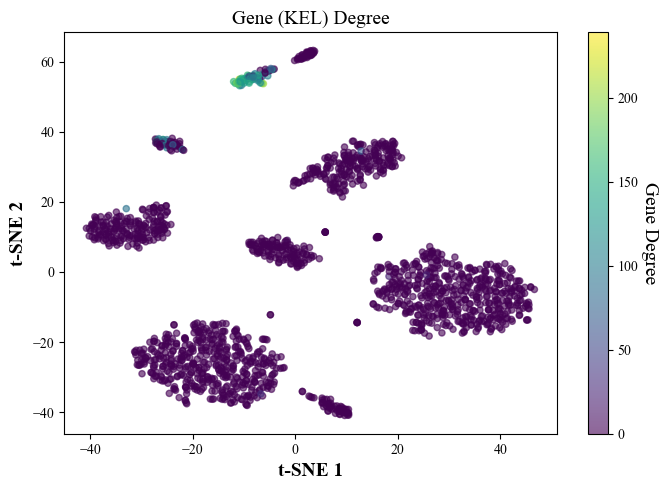

In [35]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os

pathjoin = os.path.join

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']
genes = seq_dict['gene_symbol']

all_filtered_genes_file = '../../dataset/5fold_data/Baron_Human/Baron_Human_filtered_hvgs2000.npy'

all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

gene_hvgs = genes[filtered_genes_index]

print(gene_hvgs)


pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])


degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])



lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]

    print(gene_hvgs[1168])
    target_gene_degree = degree_f3[1168]
    
    gene_degrees = target_gene_degree

    print("Embedding shape:", cur_cell_emb.shape) 
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,        
                learning_rate='auto')

    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=gene_degrees,  # 使用degree值作为颜色
                        cmap='viridis',  # 使用viridis颜色图
                        alpha=0.6,
                        s=20)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Gene Degree', rotation=270, labelpad=15,
                   fontsize=14)
    plt.title(f'Gene (KEL) Degree', 
                fontsize=14)
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7G.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7G.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    plt.show()

(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
GPR4
Embedding shape: (1712, 64)
Number of unique labels: 13


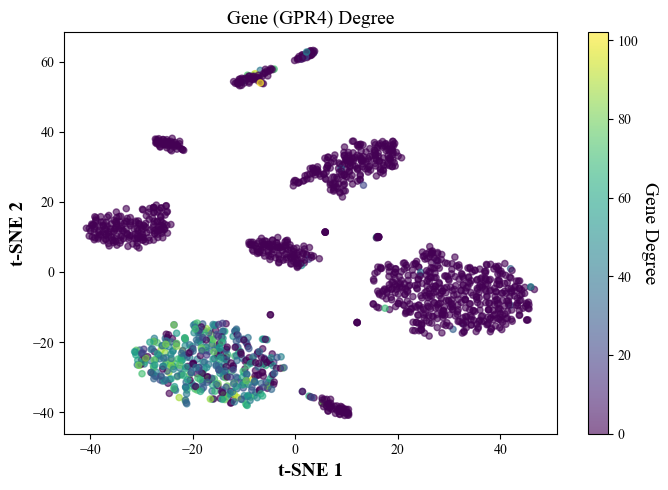

In [36]:
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']
genes = seq_dict['gene_symbol']

all_filtered_genes_file = '../../dataset/5fold_data/Baron_Human/Baron_Human_filtered_hvgs2000.npy'

all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

gene_hvgs = genes[filtered_genes_index]

print(gene_hvgs)


pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])


degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])


lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]

    # 获取第1710号基因的degree值
    print(gene_hvgs[959])
    target_gene_degree = degree_f3[959]
    
    gene_degrees = target_gene_degree

    print("Embedding shape:", cur_cell_emb.shape)  
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,         
                learning_rate='auto')

    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=gene_degrees,  
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Gene Degree', rotation=270, labelpad=15,
                   fontsize=14)
    plt.title(f'Gene (GPR4) Degree', 
                fontsize=14)
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7D.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7D.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    plt.show()

(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
ADAMTS17
Embedding shape: (1712, 64)
Number of unique labels: 13


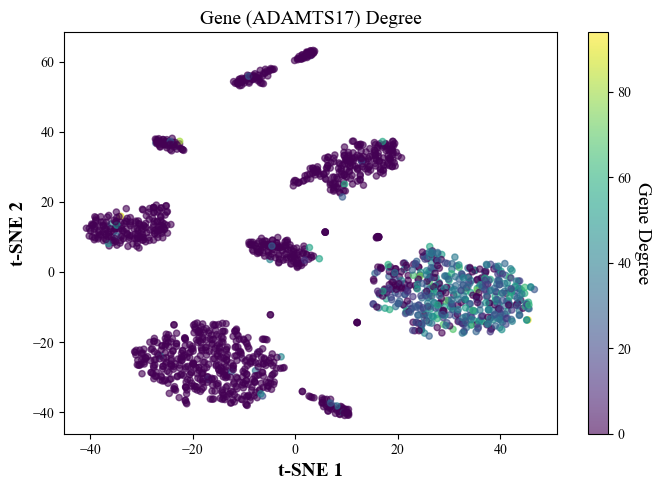

In [37]:
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']
genes = seq_dict['gene_symbol']

all_filtered_genes_file = '../../dataset/5fold_data/Baron_Human/Baron_Human_filtered_hvgs2000.npy'

all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

gene_hvgs = genes[filtered_genes_index]

print(gene_hvgs)


pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])


degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])


lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]

    print(gene_hvgs[38])
    target_gene_degree = degree_f3[38]

    gene_degrees = target_gene_degree
    print("Embedding shape:", cur_cell_emb.shape)  
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,    
                n_iter=1000,        
                learning_rate='auto')

    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=gene_degrees,  
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Gene Degree', rotation=270, labelpad=15,
                   fontsize=14)
    plt.title(f'Gene (ADAMTS17) Degree', 
                fontsize=14)
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7C.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7C.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    plt.show()

(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
DMWD
Embedding shape: (1712, 64)
Number of unique labels: 13


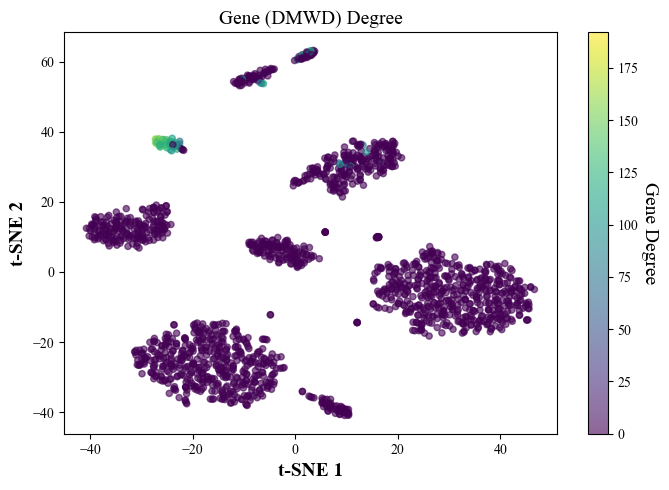

In [40]:
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']
genes = seq_dict['gene_symbol']

all_filtered_genes_file = '../../dataset/5fold_data/Baron_Human/Baron_Human_filtered_hvgs2000.npy'

all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

gene_hvgs = genes[filtered_genes_index]

print(gene_hvgs)


pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])


degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])


lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]

    print(gene_hvgs[607])
    target_gene_degree = degree_f3[607]
    
    gene_degrees = target_gene_degree

    print("Embedding shape:", cur_cell_emb.shape)  
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,         
                learning_rate='auto')

    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=gene_degrees,  
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Gene Degree', rotation=270, labelpad=15,
                   fontsize=14)
    plt.title(f'Gene (DMWD) Degree', 
                fontsize=14)
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7F.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7F.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')
    plt.show()

(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
FZD5
Embedding shape: (1712, 64)
Number of unique labels: 13


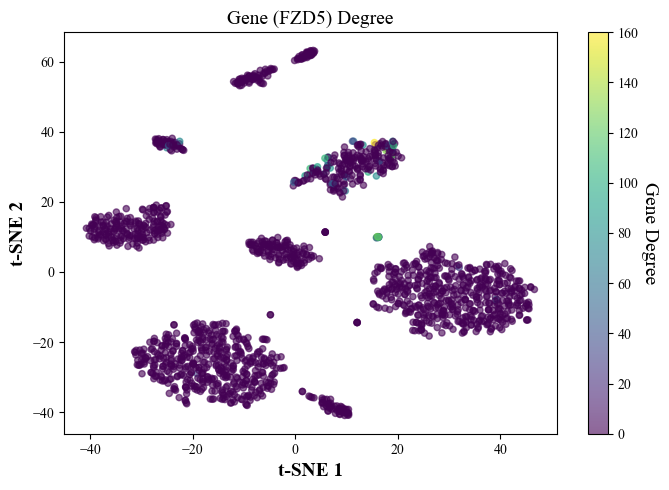

In [41]:
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']
genes = seq_dict['gene_symbol']

all_filtered_genes_file = '../../dataset/5fold_data/Baron_Human/Baron_Human_filtered_hvgs2000.npy'

all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

gene_hvgs = genes[filtered_genes_index]

print(gene_hvgs)


pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])


degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])


lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]

    print(gene_hvgs[837])
    target_gene_degree = degree_f3[837]
    

    gene_degrees = target_gene_degree

    print("Embedding shape:", cur_cell_emb.shape) 
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,         

                learning_rate='auto')

    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=gene_degrees, 
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Gene Degree', rotation=270, labelpad=15,
                   fontsize=14)
    plt.title(f'Gene (FZD5) Degree', 
                fontsize=14)
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()


    plt.savefig(f'../../result/Figures/Figure_7H.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7H.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    plt.show()

#### Figure 7F-K, Baron_Human: T-SNE (edge)

In [ ]:
import numpy as np
import pandas as pd
import os

def get_union_edges(npz_file):
   """Get the union of top edges across all 5 folds for a specific cell type."""
   # Load the npz file
   data = np.load(npz_file, allow_pickle=True)
   
   # Set to store all edges
   all_edges = set()
   
   # Iterate through the 5 folds
   for i in range(1, 6):
       fold_key = f'fold_{i}_edges'
       if fold_key in data:
           edges = data[fold_key]
           # Convert each edge to string format and add to the set
           edge_strings = [f"{int(edge[0])}-{int(edge[1])}" for edge in edges]
           all_edges.update(edge_strings)
   print(list(all_edges))
   return sorted(list(all_edges))  # Return the sorted list of edges


# Load seq_dict file containing metadata for the cells
seq_dict_file = '../../dataset/5fold_data//Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
# genes_id = seq_dict['gene_id']  # genes_id not used in this script
label = seq_dict['label']
str_labels = seq_dict['str_labels']

# Process the three cell types
cell_types = str_labels.tolist()  # Replace with actual cell type names
edges_dict = {}

# Iterate through each cell type and process its corresponding top edges file
for cell_type in cell_types:
   npz_file = f'data/Baron_Human/Baron_Human_top_edges/{cell_type}_top_edges.npz'  # Path to npz file
   if os.path.exists(npz_file):
        edges_dict[cell_type] = get_union_edges(npz_file)

# Find the length of the longest list
max_length = max(len(edges) for edges in edges_dict.values())

# Pad the shorter lists with empty values to match the maximum length
for cell_type in edges_dict:
   if len(edges_dict[cell_type]) < max_length:
       edges_dict[cell_type].extend([''] * (max_length - len(edges_dict[cell_type])))

# Create a DataFrame from the edges dictionary
df = pd.DataFrame(edges_dict)
print(df.columns)

# Save the DataFrame as a TSV file
save_path = 'data/Baron_Human/Baron_Human_top_edges/union_edges.tsv'
df.to_csv(save_path, sep='\t', index=False)

print(f"Save completed: {save_path}")

# Print some basic statistics
print("\nNumber of edges for each cell type:")

for cell_type in cell_types:
   # Count the number of non-empty values
   edge_count = len([x for x in edges_dict[cell_type] if x != ''])
   print(f"{cell_type}: {edge_count} edges")


In [ ]:
Baron_Human_union_edges_file = 'data/Baron_Human/Baron_Human_top_edges/union_edges.tsv'
Baron_Human_union_edges = pd.read_csv(Baron_Human_union_edges_file, sep='\t', header=0)
print(Baron_Human_union_edges)
columns = Baron_Human_union_edges.columns.tolist()

sets = {}
# Create a set for each column of edges
for col in columns:
    sets[col] = set(Baron_Human_union_edges[col].dropna().values)

# Print the size of each set
print("\nSize of each set:")
for col, s in sets.items():
    print(f"{col}: {len(s)} edges")

# Calculate the unique edges for cell type
unique_edges = {}
for col in columns:
    # Compute edges that only appear in the current set
    unique = sets[col] - set.union(*[sets[c] for c in columns if c != col])
    unique_edges[col] = unique
    print(f"\nNumber of unique edges only in {col}: {len(unique)}")
    if len(unique) > 0:
        print("List of unique edges:")
        print(unique)


In [ ]:
import numpy as np
import pandas as pd

# Get the union of the edges
all_edges = set.union(*sets.values())

# Function to extract node indices from edge strings
def extract_node_indices(edge_str):
    # Split the string and convert to integers
    node1, node2 = edge_str.split('-')
    return int(node1), int(node2)

# Create a list to store all node indices
all_nodes = set()
edge_pairs = []

# Process each edge and extract the nodes
for edge_str in all_edges:
    node1, node2 = extract_node_indices(edge_str)
    edge_pairs.append((node1, node2))
    all_nodes.add(node1)
    all_nodes.add(node2)

# Convert the edge pairs to a numpy array for further processing
edge_array = np.array(edge_pairs)

# Print the results
print(f"\nTotal number of edges: {len(all_edges)}")
print(f"Number of unique nodes involved: {len(all_nodes)}")

# Create a DataFrame to display the edge pairs
edges_df = pd.DataFrame(edge_pairs, columns=['Node1', 'Node2'])
print("\nExample of the first few edges:")
print(edges_df.head())

# Get the sorted list of unique node indices
unique_nodes = sorted(list(all_nodes))
print("\nList of node indices (first 10):")
print(unique_nodes[:10])

# Basic statistics
print("\nBasic statistics:")
print(f"Minimum node index: {min(all_nodes)}")
print(f"Maximum node index: {max(all_nodes)}")

# Provide the same analysis for each original set
print("\nDetailed information for each set:")
for col in columns:
    current_edges = sets[col]
    current_nodes = set()
    for edge_str in current_edges:
        node1, node2 = extract_node_indices(edge_str)
        current_nodes.add(node1)
        current_nodes.add(node2)
    print(f"\n{col}:")
    print(f"Number of edges: {len(current_edges)}")
    print(f"Number of nodes: {len(current_nodes)}")

# Return the main data structures for further use
result = {
    'edge_pairs': edge_array,  # Edge pairs as a numpy array
    'node_set': all_nodes,     # Set of all nodes
    'edges_df': edges_df       # DataFrame of edge list
}

# Save the edge list DataFrame to a TSV file
edges_df.to_csv('data/Baron_Human/Baron_Human_top_edges/all_union_edges.tsv', sep='\t', header=True, index=False)

In [ ]:
import numpy as np
import torch
import os
from tqdm import tqdm
import pandas as pd
from scipy import sparse

def process_cell_graph(cell_data, target_edges):
    """Process the graph data of a single cell and extract the weights of target edges.
    Args:
        cell_data: Graph data containing edge_index and edge_weight
        target_edges: DataFrame containing the target edges (Node1, Node2) where Node1 < Node2
    Returns:
        np.array: Array of edge weights for the target edges
    """
    # Get edge indices and weights from the cell data
    edge_index = cell_data.edge_index
    edge_weight = cell_data.edge_weight
    
    # Create a dictionary mapping edges to their corresponding weights
    edge_weight_dict = dict(zip(
        [f"{src}-{dst}" for src, dst in zip(edge_index[0].tolist(), edge_index[1].tolist())],
        edge_weight.tolist()
    ))
    
    # Get the weights for the target edges
    edge_weights = [
        edge_weight_dict.get(f"{row['Node1']}-{row['Node2']}", 0.0) 
        for _, row in target_edges.iterrows()
    ]
    
    return np.array(edge_weights)


def extract_edge_weights(seq_dict_file, edges_df, gene_hvgs, batch_size=100):
    """Extract edge weight matrices for all folds."""
    # Load the sequence dictionary
    seq_dict = np.load(seq_dict_file, allow_pickle=True)
    edge_weight_matrices = {}

    # Generate column names using gene pairs
    column_names = [f"{row['Node1']}-{row['Node2']}" 
                   for _, row in edges_df.iterrows()]

    # Process each fold (1 to 5)
    for k in range(5):
        k_fold = k + 1
        print(f"\nProcessing Fold {k_fold}...")
        
        # Get the test indices for the current fold
        test_index = seq_dict[f'test_index_{k_fold}']
        
        # Define the path to the processed data folder
        cell_test_folder = f'../../dataset/5fold_data/Baron_Human/wcsn_a0.01_hvgs2000_/test_f{k_fold}/processed'
        
        # Initialize the matrix to store edge weights for the current fold
        edge_weight_matrix = []
        
        # Process the data in batches
        for i in tqdm(range(0, len(test_index), batch_size), desc=f"Fold {k_fold}"):
            batch_indices = range(i, min(i + batch_size, len(test_index)))
            batch_weights = []
            
            for idx in batch_indices:
                # Load cell data
                cell_data = torch.load(os.path.join(cell_test_folder, f'cell_{idx}.pt'))
                # Process the graph data for the current cell
                cell_edge_weights = process_cell_graph(cell_data, edges_df)
                batch_weights.append(cell_edge_weights)
            
            # Add the batch results to the main matrix
            edge_weight_matrix.extend(batch_weights)

        # Convert the matrix to a DataFrame
        df = pd.DataFrame(edge_weight_matrix, columns=column_names)
        
        # Set the cell barcodes as the index
        df.index = barcodes[test_index]
        
        edge_weight_matrices[f'CV_{k_fold}'] = df
        
        print(f"Fold {k_fold} DataFrame shape: {df.shape}")
        print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    return edge_weight_matrices

# Main program execution
if __name__ == "__main__":
    # Set file paths
    seq_dict_file = '../../dataset/5fold_data//Baron_Human/seq_dict.npz'
    output_file = 'data/Baron_Human/edge_weight_matrices_Baron_Human_per_fold_a0.01_hvgs2000.h5'
    
    # Load gene symbols
    seq_dict = np.load(seq_dict_file, allow_pickle=True) 
    genes = seq_dict['gene_symbol']

    # Load filtered genes data
    all_filtered_genes_file = '../../dataset/5fold_data/Baron_Human/Baron_Human_filtered_hvgs2000.npy'

    # Load the filtered gene indices
    all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
    filtered_genes_index = all_filtered_genes_array[0]
    filtered_genes_index = filtered_genes_index.astype(int)
    print(filtered_genes_index.shape)

    # Extract the highly variable genes
    gene_hvgs = genes[filtered_genes_index]

    # Extract edge weight matrices for all folds
    edge_weight_matrices = extract_edge_weights(seq_dict_file, edges_df, gene_hvgs)
    
    # Save the matrices as HDF5 files
    with pd.HDFStore(output_file, mode='w') as store:
        for fold, df in edge_weight_matrices.items():
            store[fold] = df
    print(f"\nResults saved to: {output_file}")
    
    # Verify the saved results
    print("\nVerifying saved DataFrames:")
    with pd.HDFStore(output_file, mode='r') as store:
        for fold in store.keys():
            df = store[fold]
            print(f"\n{fold}:")
            print(f"Shape: {df.shape}")
            print(f"Columns (first 5): {df.columns[:5]}")
            print(f"Index (first 5): {df.index[:5]}")
            print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")


(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
CCDC157
NOTUM
Embedding shape: (1712, 64)
Number of unique labels: 13


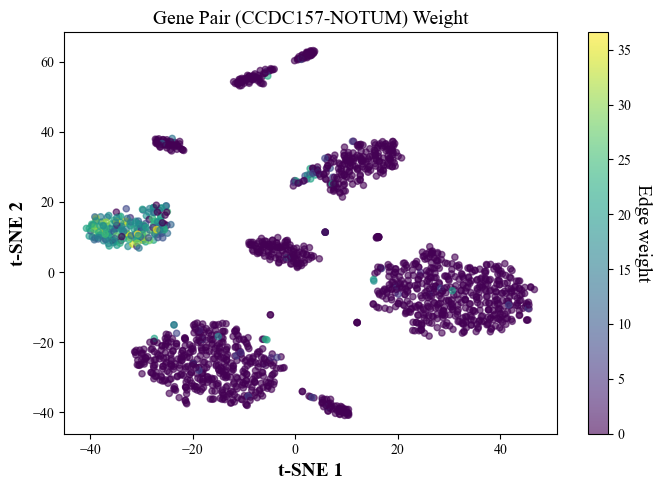

In [42]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']

pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])

degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])

lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]

    fold_df = pd.read_hdf('data/Baron_Human/edge_weight_matrices_Baron_Human_per_fold_a0.01_hvgs2000.h5', 
                        key=f'CV_{k_fold}')

    target_gene_degree = fold_df['344-1441']
    print(gene_hvgs[344])
    print(gene_hvgs[1441])

    edge_w = target_gene_degree

    print("Embedding shape:", cur_cell_emb.shape)  
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,         
                learning_rate='auto')

    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=edge_w,  
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Edge weight', rotation=270, labelpad=15,
                   fontsize=14)

    plt.title(f'Gene Pair (CCDC157-NOTUM) Weight', 
                fontsize=14)
    
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7K.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7K.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    plt.show()

In [43]:
import numpy as np
import pandas as pd

seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
output_file = 'Tables/Baron_Human/edge_weight_matrices_Baron_Human_per_fold_a0.01_hvgs2000.h5'

# 读取基因名称
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
genes = seq_dict['gene_symbol']

all_filtered_genes_file = '../../dataset/5fold_data//Baron_Human/Baron_Human_filtered_hvgs2000.npy'

# 得到每一折的基因数量：
# genes_num_all = get_gene_num(all_filtered_genes_file)
all_filtered_genes_array = np.load(all_filtered_genes_file, allow_pickle=True)
filtered_genes_index = all_filtered_genes_array[0]
filtered_genes_index = filtered_genes_index.astype(int)
print(filtered_genes_index.shape)

gene_hvgs = genes[filtered_genes_index]
print(gene_hvgs)

(2000,)
['A2M' 'A4GALT' 'AACSP1' ... 'TIMM8A' 'TIMMDC1' 'TJP2']


(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
CEP19
SAP18
Embedding shape: (1712, 64)
Number of unique labels: 13


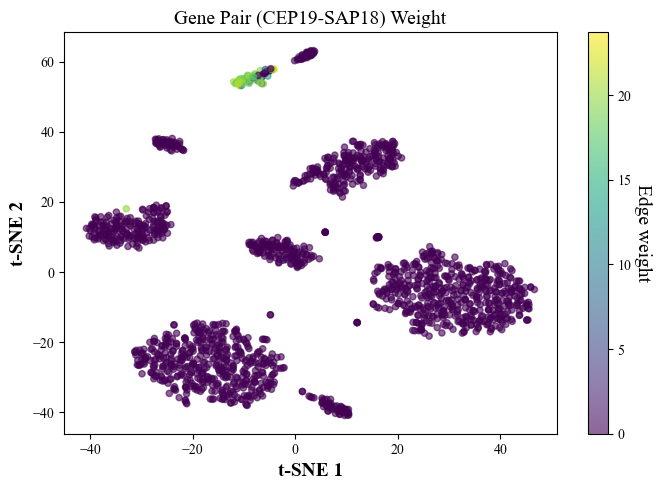

In [44]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os

pathjoin = os.path.join

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']


pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])

degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])


lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]

    fold_df = pd.read_hdf('data/Baron_Human/edge_weight_matrices_Baron_Human_per_fold_a0.01_hvgs2000.h5', 
                        key=f'CV_{k_fold}')

    target_gene_degree = fold_df['426-1825']
    print(gene_hvgs[426])
    print(gene_hvgs[1825])
    edge_w = target_gene_degree


    print("Embedding shape:", cur_cell_emb.shape)  
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,         
                learning_rate='auto')

    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=edge_w,  
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Edge weight', rotation=270, labelpad=15,
                   fontsize=14)

    plt.title(f'Gene Pair (CEP19-SAP18) Weight', 
                fontsize=14)
    
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7L.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7L.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')
    plt.show()

(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
IL21R
SLC35F5
Embedding shape: (1712, 64)
Number of unique labels: 13


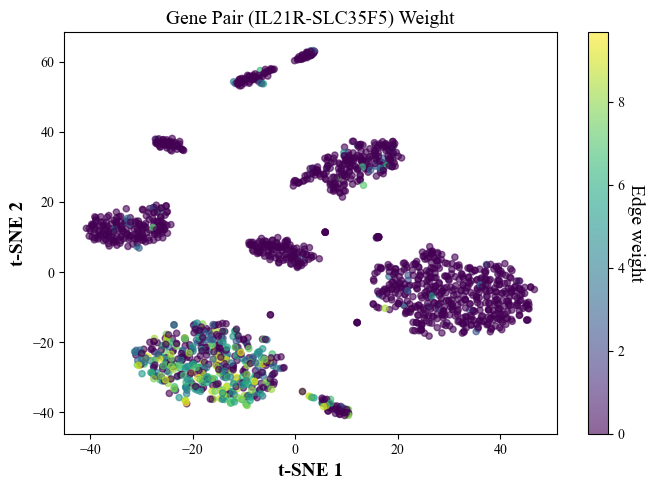

In [45]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os

pathjoin = os.path.join

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']

pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_hdgs0_hvdgs0_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])


degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])

lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]



    fold_df = pd.read_hdf('data/Baron_Human/edge_weight_matrices_Baron_Human_per_fold_a0.01_hvgs2000.h5', 
                        key=f'CV_{k_fold}')

    target_gene_degree = fold_df['1129-1908']
    print(gene_hvgs[1129])
    print(gene_hvgs[1908])
    edge_w = target_gene_degree

    print("Embedding shape:", cur_cell_emb.shape)  
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,         
                learning_rate='auto')

    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=edge_w,  
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Edge weight', rotation=270, labelpad=15,
                   fontsize=14)

    plt.title(f'Gene Pair (IL21R-SLC35F5) Weight', 
                fontsize=14)
    
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7I.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7I.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    plt.show()

(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
IGF2BP3
SIAH2
Embedding shape: (1712, 64)
Number of unique labels: 13


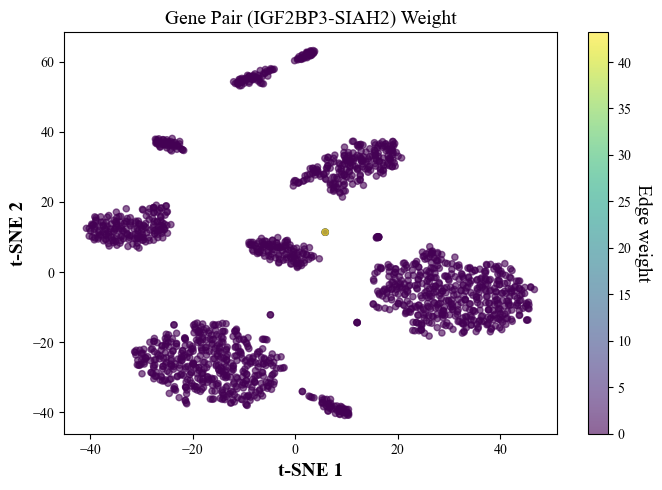

In [46]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os

pathjoin = os.path.join

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']

pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_hdgs0_hvdgs0_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])


degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])


lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]
    fold_df = pd.read_hdf('data/Baron_Human/edge_weight_matrices_Baron_Human_per_fold_a0.01_hvgs2000.h5', 
                        key=f'CV_{k_fold}')


    target_gene_degree = fold_df['1114-1880']
    print(gene_hvgs[1114])
    print(gene_hvgs[1880])
    edge_w = target_gene_degree


    print("Embedding shape:", cur_cell_emb.shape)  
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,     
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,         
                learning_rate='auto')

    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=edge_w, 
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Edge weight', rotation=270, labelpad=15,
                   fontsize=14)

    plt.title(f'Gene Pair (IGF2BP3-SIAH2) Weight', 
                fontsize=14)
    
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7N.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7N.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    plt.show()

(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
BTBD10
CARD8
Embedding shape: (1712, 64)
Number of unique labels: 13


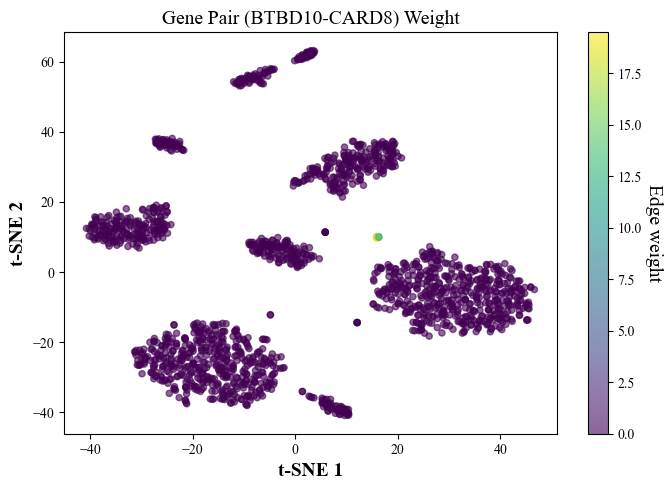

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os

pathjoin = os.path.join

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']

pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_hdgs0_hvdgs0_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])


degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])


lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]
    fold_df = pd.read_hdf('data/Baron_Human/edge_weight_matrices_Baron_Human_per_fold_a0.01_hvgs2000.h5', 
                        key=f'CV_{k_fold}')

    target_gene_degree = fold_df['209-313']
    print(gene_hvgs[209])
    print(gene_hvgs[313])

    edge_w = target_gene_degree


    print("Embedding shape:", cur_cell_emb.shape)  
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,      
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,         
                learning_rate='auto')

    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())

    plt.figure(figsize=(7, 5))

    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=edge_w,  
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Edge weight', rotation=270, labelpad=15,
                   fontsize=14)

    plt.title(f'Gene Pair (BTBD10-CARD8) Weight', 
                fontsize=14)
    
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7M.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7M.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    plt.show()


(2000,)
['A2M' 'A4GALT' 'AACSP1' ... 'TIMM8A' 'TIMMDC1' 'TJP2']
(8562, 64)
(8562, 2)
                             pred_cell_type  true_cell_type
human1_lib1.final_cell_0005               0               0
human1_lib1.final_cell_0022               2               2
human1_lib1.final_cell_0030               3               3
human1_lib1.final_cell_0035               3               3
human1_lib1.final_cell_0036               0               0
(2000, 1712)
[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [136.  88.   0.   0. 146.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]
k_fold:  3
GLRB
GPATCH11
Embedding shape: (1712, 64)
Number of unique labels: 13


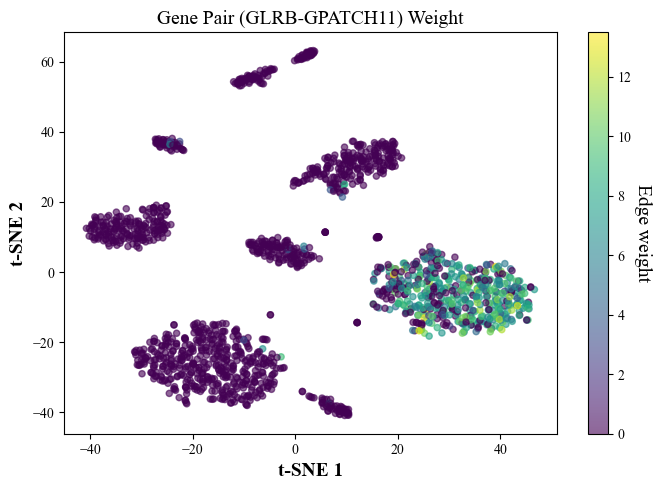

In [9]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os

pathjoin = os.path.join

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


seq_dict_file = '../../dataset/5fold_data/Baron_Human/seq_dict.npz'
seq_dict = np.load(seq_dict_file, allow_pickle=True) 
label = seq_dict['label']
str_labels = seq_dict['str_labels']
barcodes = seq_dict['barcode']

pred_path = '../../result/preds/Baron_Human_HumanNet-GSP_a0.01_hvgs2000_hdgs0_hvdgs0_prediction.h5'

cell_embedding = pd.read_hdf(pred_path, key='embedding')

cell_type = pd.read_hdf(pred_path, key='cell_type')
pred_prob = pd.read_hdf(pred_path, key='pred_prob')
print(cell_embedding.shape)
print(cell_type.shape)
print(cell_type[:5])


degree_file = pathjoin('../../dataset/5fold_data/Baron_Human/', f'degree_matrix_Baron_Human_per_fold_a0.01_hvgs2000.npz')
degree_fold = np.load(degree_file, allow_pickle=True)
degree_f3 = degree_fold['CV_3']
print(degree_f3.shape)
print(degree_f3[:5, :5])


lst = [2]
for k in lst:
    k_fold = k + 1
    print("k_fold: ", k_fold)
    test_index = seq_dict[f'test_index_{k_fold}']
    barcodes_test = barcodes[test_index]
    cur_cell_emb = cell_embedding.loc[barcodes_test]
    fold_df = pd.read_hdf('data/Baron_Human/edge_weight_matrices_Baron_Human_per_fold_a0.01_hvgs2000.h5', 
                        key=f'CV_{k_fold}')

    target_gene_degree = fold_df['909-948']
    print(gene_hvgs[909])
    print(gene_hvgs[948])
    edge_w = target_gene_degree

    print("Embedding shape:", cur_cell_emb.shape)  
    print("Number of unique labels:", len(np.unique(cell_type['true_cell_type'].loc[barcodes_test])))

    perp = 30
    ee = 12
    tsne = TSNE(n_components=2,     
                perplexity=perp,       
                early_exaggeration=ee,
                random_state=42,     
                n_iter=1000,         
                learning_rate='auto')


    embeddings_2d = tsne.fit_transform(cur_cell_emb.to_numpy())
    plt.figure(figsize=(7, 5))


    scatter = plt.scatter(embeddings_2d[:, 0], 
                        embeddings_2d[:, 1],
                        c=edge_w,  
                        cmap='viridis',  
                        alpha=0.6,
                        s=20)
    
    cbar = plt.colorbar(scatter)
    cbar.set_label('Edge weight', rotation=270, labelpad=15,
                   fontsize=14)

    plt.title(f'Gene Pair (GLRB-GPATCH11) Weight', 
                fontsize=14)
    
    plt.xlabel('t-SNE 1', fontsize=14,fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=14,fontweight='bold')

    plt.tight_layout()

    plt.savefig(f'../../result/Figures/Figure_7J.svg', 
                dpi=1200, 
                bbox_inches='tight',
                format='svg')

    plt.savefig(f'../../result/Figures/Figure_7J.png', 
                dpi=1200, 
                bbox_inches='tight',
                format='png')

    plt.show()

#### Figure 5N, Upset

In [ ]:
import pandas as pd
import numpy as np
from upsetplot import from_memberships
from upsetplot import UpSet
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

file_path = "data/Baron_Human/Gene_degree/Baron_Human_merged_top100_genes.tsv"
data = pd.read_csv(file_path, sep="\t", header=0, na_values="NA")


cell_type_sets = {}
for column in data.columns:
    genes = set(data[column].dropna().values)
    cell_type_sets[column] = genes

all_genes = list(set.union(*cell_type_sets.values()))
cell_types = list(cell_type_sets.keys())
binary_matrix = pd.DataFrame(0, index=all_genes, columns=cell_types)

for gene in all_genes:
    for cell_type in cell_types:
        if gene in cell_type_sets[cell_type]:
            binary_matrix.loc[gene, cell_type] = 1

combinations = binary_matrix.apply(tuple, axis=1)
combination_counts = combinations.value_counts()

membership_lists = []
for comb in combination_counts.index:
    current_members = []
    for i, v in enumerate(comb):
        if v:
            current_members.append(cell_types[i])
    membership_lists.append(current_members)

upset_data = from_memberships(
    membership_lists,
    data=combination_counts.values
)

plt.figure(figsize=(3, 1))

upset = UpSet(upset_data,
              min_subset_size=3,
              show_counts=True,
              sort_by='cardinality',
              element_size=20,
              facecolor='#34495e',           
              other_dots_color=0.3,          
              shading_color='#f5f6fa',
              )       

upset.plot()
plt.tight_layout()

plt.savefig('../../result/Figures/Figure_5N.png', dpi=1200, bbox_inches='tight',format='png')
plt.show()

#### Figure 6N, Upset

In [ ]:
import pandas as pd
import numpy as np
from upsetplot import from_memberships
from upsetplot import UpSet
import matplotlib.pyplot as plt


file_path = "data/Baron_Human/Baron_Human_top_edges/union_edges.tsv"
data = pd.read_csv(file_path, sep="\t", header=0, na_values="NA")
cell_type_sets = {}
for column in data.columns:
    genes = set(data[column].dropna().values)
    cell_type_sets[column] = genes

all_genes = list(set.union(*cell_type_sets.values()))
cell_types = list(cell_type_sets.keys())
binary_matrix = pd.DataFrame(0, index=all_genes, columns=cell_types)

for gene in all_genes:
    for cell_type in cell_types:
        if gene in cell_type_sets[cell_type]:
            binary_matrix.loc[gene, cell_type] = 1

combinations = binary_matrix.apply(tuple, axis=1)
combination_counts = combinations.value_counts()

membership_lists = []
for comb in combination_counts.index:
    current_members = []
    for i, v in enumerate(comb):
        if v:
            current_members.append(cell_types[i])
    membership_lists.append(current_members)

upset_data = from_memberships(
    membership_lists,
    data=combination_counts.values
)

plt.figure(figsize=(10, 5))

upset = UpSet(upset_data,
              min_subset_size=3,
              show_counts=True,
              sort_by='cardinality',
              element_size=20,
              facecolor='#34495e',           
              other_dots_color=0.3,         
              shading_color='#f5f6fa',
              )      

upset.plot()

plt.tight_layout()
plt.savefig('../../result/Figures/Figure_6N.svg', dpi=1200, bbox_inches='tight',format='svg')
plt.savefig('../../result/Figures/Figure_6N.png', dpi=1200, bbox_inches='tight',format='png')

plt.show()
plt.close()
